# A time-varying PDE with forcing

In a previous example of the Poisson equation we demonstrated the use of point forcing. In this example
we will explore other ways to apply forcing to a PDE. Our target
problem will be similar to the most recent example -- transient heat conduction --
but now it will be in an unbounded domain. Our forcing will comprise local
*area heating* and *line heating*. We will also include convection by an
externally-imposed velocity field.

The governing equations are

$$\dfrac{\partial T}{\partial t} + \mathbf{v}\cdot\nabla T = \kappa \nabla^2 T + q$$

where $\mathbf{v}$ is a known convection velocity field and $q$ is a known heating field (scaled
by the density and specific heat)

In our discrete formulation, the problem takes the form

$$\mathcal{L}_C^\kappa T = -N(\mathbf{v},T) + q$$

where $N$ is a discrete approximation for the convection term $\mathbf{v}\cdot\nabla T$,
and $\mathcal{L}_C^\kappa = \mathrm{d}/\mathrm{d}t - \kappa L_C$ is the same
diffusion operator as in the previous example. Note that these equations are
no longer constrained. We only need to supply the right-hand side function.
Our job here is to provide everything needed to compute this right-hand side.

We will apply the heating and cooling inside of local regions.
As we discussed before, for each forcing, we supply information about the **shape**
of the forcing region and the **model function**, supplying the forcing strength
whenever we need it. We package these together into a forcing model and
provide it to the problem via the `forcing` keyword.

The convection velocity also must be provided. We also make use of the `forcing`
keyword to supply this to the problem, as well, in the form of a function
that returns the current convection velocity at a given time `t`. The
convective derivative term `N` requires a special cache, which we also
generate in the `prob_cache`.

We will highlight these aspects in the example that follows. In this example,
we will create
* a square-shaped line forcing region that delivers a certain amount of heat per unit length of line
* a circular-shaped area forcing region that supplies heat based on the heat-transfer model $h\cdot(T_0\cos(2\pi f t)-T)$, where $h$ is the heat transfer coefficient, $T$ is the current local temperature,
and $T_0$ is the amplitude of an oscillatory heater temperature, oscillating
at frequency $f$
* a background rotational velocity field, with angular velocity $\Omega$.

In [1]:
using ComputationalHeatTransfer
using Plots

### Set up the grid
Let's set up the grid first before we go any further

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

### Specify the physical parameters
We supply here the diffusivity ($\kappa$) and the uniform convection velocity.
We also supply the grid Fourier number and a CFL number, which we will make
use of later to calculate the time step size.

In [3]:
phys_params = Dict("diffusivity" => 0.005,
                    "angular velocity" => 0.5,
                    "length scale" => Lx/2,
                     "Fourier" => 1.0,
                     "CFL" => 0.5,
                     "lineheater_flux" => -2.0,
                     "areaheater_freq" => 1.0,
                     "areaheater_temp" => 2.0,
                     "areaheater_coeff" => 100.0
                     )

Dict{String, Float64} with 9 entries:
  "areaheater_coeff" => 100.0
  "Fourier"          => 1.0
  "areaheater_temp"  => 2.0
  "CFL"              => 0.5
  "diffusivity"      => 0.005
  "length scale"     => 2.0
  "lineheater_flux"  => -2.0
  "angular velocity" => 0.5
  "areaheater_freq"  => 1.0

## Specifying the forcing regions and models and convection velocity model
We first create the square line heater and place it at $(0,1)$. Its
associated model function is very simple, since it just sets the
strength uniformly. But note the function signature, which must always take this
form. It can make use of the current temperature, time, and physical parameters,
to return the strength of the line forcing. We bundle these together
using `LineForcingModel`.

In [4]:
fregion1 = Square(0.5,1.4*Δx)
tr1 = RigidTransform((0.0,1.0),0.0)

function model1!(σ,T,t,fr::LineRegionCache,phys_params)
    σ .= phys_params["lineheater_flux"]
end
lfm = LineForcingModel(fregion1,tr1,model1!);

Now the oscillatory heater, which we place at $(0,-0.5)$. This one has a few more parameters,
since we provide the heat transfer coefficient and the amplitude and frequency
of the target temperature. These are bundled with `AreaForcingModel`.

In [5]:
fregion2 = Circle(0.2,1.4*Δx)
tr2 = RigidTransform((0.0,-0.5),0.0)

function model2!(σ,T,t,fr::AreaRegionCache,phys_params)
    f = phys_params["areaheater_freq"]
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    σ .= h*(T0*cos(2π*f*t) - T)
end
afm = AreaForcingModel(fregion2,tr2,model2!);

Finally, the convection velocity model. Here, we make use of the
coordinate function `x_gridgrad` and `y_gridgrad`
to supply the coordinates of the velocity grid points. Since this
is a staggered grid, the velocity components live at different places.
For example, `yg.u` denotes the $y$ coordinates for the horizontal velocity
components, and `xg.v` denotes the $x$ coordinates for the vertical
velocity components.

In [6]:
function my_velocity!(vel,t,cache,phys_params)
    xg, yg = x_gridgrad(cache), y_gridgrad(cache)
    Ω = phys_params["angular velocity"]
    vel.u .= -Ω*yg.u
    vel.v .= Ω*xg.v
    return vel
end

my_velocity! (generic function with 1 method)

As in the last example, we also define the temperature output function for output

In [7]:
temperature(T,σ,x,sys::ILMSystem,t) = T
@snapshotoutput temperature

We pack the forcing and convection together into the _forcing_ `Dict`.

In [8]:
forcing_dict = Dict("heating models" => [lfm,afm],
                    "convection velocity model" => my_velocity!)

Dict{String, Any} with 2 entries:
  "convection velocity model" => my_velocity!
  "heating models"            => AbstractForcingModel[LineForcingModel{Polygon{…

## Set up the problem and system
This is similar to previous problems.

In [9]:
prob = DirichletHeatConductionProblem(g,scaling=GridScaling,
                                        phys_params=phys_params,
                                        forcing=forcing_dict,
                                        timestep_func=timestep_fourier_cfl)

sys = construct_system(prob);

## Solve the problem
As before, we first initialize the state, then we create an integrator,
and finally, advance the solution in time

In [10]:
u0 = init_sol(sys)
tspan = (0.0,2.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 406, ny = 406) cell grid of type Float64 data
  Number of Primal nodes: (nx = 405, ny = 405), Float64[])

Run the problem for one time unit

In [11]:
step!(integrator,1.0)

Let's see what this looks like. We will plot a set of snapshots in an array.

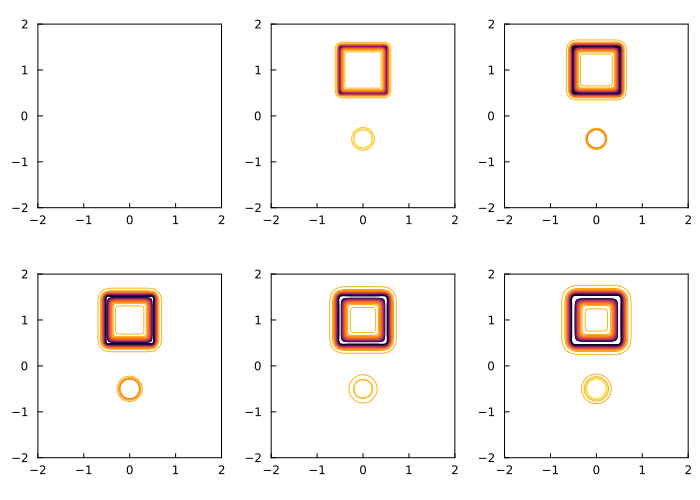

In [12]:
sol = integrator.sol

plt = plot(layout = (2,3), size = (700, 500), legend=:false)
for (i,t) in enumerate(0:0.2:1.0)
   plot!(plt[i],temperature(sol,sys,t),sys,levels=range(-10,2,length=30),clim=(-10,2))
end
plt

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*